In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import numpy as np
from io import StringIO

# ==========================================
# 1. CHUẨN BỊ DỮ LIỆU (Giữ nguyên)
# ==========================================
file_content = """IdStart	IdEnd	Length
0	19	50.0
0	4	50.7
1	20	23.5
2	1	26.5
3	20	33.8
4	7	49.3
5	6	39.8
6	7	50.0
7	8	48.1
7	23	45.0
8	22	51.9
9	10	25.4
10	24	19.1
11	12	22.9
12	13	29.0
13	14	44.5
14	15	26.5
15	18	100.0
16	9	109.0
17	11	77.2
18	2	200.0
19	21	50.0
19	5	60.2
20	0	50.0
21	16	46.5
22	18	100.0
23	3	4.0
24	22	100.0
24	17	100.0
"""
df = pd.read_csv(StringIO(file_content), sep='\t')
G = nx.from_pandas_edgelist(df, source='IdStart', target='IdEnd', edge_attr='Length')
for u, v in G.edges(): G[u][v]['weight'] = G[u][v]['Length']
pos = nx.spring_layout(G, seed=42)

# Lấy toàn bộ các điểm trên bản đồ làm dữ liệu phân tích
# (Để vẽ ra biểu đồ mật độ đầy đủ nhất)
all_points = list(G.nodes())

In [6]:
# ==========================================
# 2. CÀI ĐẶT THUẬT TOÁN TÍNH MẬT ĐỘ
# ==========================================

# Hàm tìm hàng xóm (Algo 1) - Dùng để đếm mật độ
def get_neighbors_count(G, start_node, eps):
    distances = {start_node: 0}
    queue = [(0, start_node)]
    count = 0
    
    while queue:
        d, u = heapq.heappop(queue)
        if d > eps: continue
        
        count += 1 # Tìm thấy 1 điểm nằm trong vùng phủ sóng
        
        for v in G.neighbors(u):
            w = G[u][v]['weight']
            new_d = d + w
            if new_d <= eps:
                if new_d < distances.get(v, float('inf')):
                    distances[v] = new_d
                    heapq.heappush(queue, (new_d, v))
    return count - 1 # Trừ chính nó ra (tùy định nghĩa, ở đây ta trừ để đếm hàng xóm)

In [7]:
# ==========================================
# 3. TRỰC QUAN HÓA THUẬT TOÁN 2
# ==========================================

def visualize_algo2_density(G, points, eps, pos):
    print(f"--- ĐANG TÍNH MẬT ĐỘ CHO {len(points)} ĐIỂM (EPS={eps}) ---")
    
    # BƯỚC 1: Tính mật độ cho từng điểm
    density_map = {}
    for p in points:
        dens = get_neighbors_count(G, p, eps)
        density_map[p] = dens
    
    # BƯỚC 2: Sắp xếp theo thứ tự giảm dần (Tạo bảng Density Ordering)
    # Đây chính là cốt lõi của Thuật toán 2
    sorted_points = sorted(density_map.items(), key=lambda item: item[1], reverse=True)
    
    # Tách dữ liệu để vẽ
    sorted_ids = [str(item[0]) for item in sorted_points]
    sorted_densities = [item[1] for item in sorted_points]
    
    # --- VẼ HÌNH 1: BIỂU ĐỒ SẮP XẾP MẬT ĐỘ (BAR CHART) ---
    plt.figure(figsize=(14, 6))
    
    # Vẽ cột
    bars = plt.bar(sorted_ids, sorted_densities, color='skyblue', edgecolor='black')
    
    # Tô màu đỏ cho những cột cao (Tiềm năng là lõi cụm)
    # Giả sử MinPts = 2
    MIN_PTS_DEMO = 2
    for bar, val in zip(bars, sorted_densities):
        if val >= MIN_PTS_DEMO:
            bar.set_color('#ff7f0e') # Màu cam đậm cho vùng lõi
            bar.set_edgecolor('black')
    
    # Vẽ đường cắt MinPts
    plt.axhline(y=MIN_PTS_DEMO, color='red', linestyle='--', linewidth=2, label=f'MinPts = {MIN_PTS_DEMO}')
    
    plt.xlabel('ID Điểm (Đã sắp xếp theo mật độ)', fontsize=12)
    plt.ylabel('Mật độ (Số lượng hàng xóm)', fontsize=12)
    plt.title(f'BIỂU ĐỒ SẮP XẾP MẬT ĐỘ (DENSITY ORDERING GRAPH)\nCác "Ngọn đồi" màu cam chính là các cụm tiềm năng', fontsize=14)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # --- VẼ HÌNH 2: BẢN ĐỒ NHIỆT MẬT ĐỘ (DENSITY HEATMAP) ---
    plt.figure(figsize=(12, 10))
    
    # Vẽ nền mờ
    nx.draw_networkx_edges(G, pos, edge_color='#CCCCCC', width=1)
    
    # Chuẩn bị màu sắc dựa trên mật độ
    # Mật độ cao -> Màu nóng (Đỏ), Mật độ thấp -> Màu lạnh (Xanh/Tím)
    node_colors = [density_map[n] for n in G.nodes()]
    
    # Vẽ các nút với màu sắc thay đổi theo mật độ (cmap='YlOrRd' = Yellow-Orange-Red)
    nodes = nx.draw_networkx_nodes(G, pos, node_size=300, 
                                   node_color=node_colors, cmap=plt.cm.YlOrRd, 
                                   edgecolors='black')
    
    # Vẽ nhãn (ID và Mật độ)
    labels = {n: f"{n}\n({d})" for n, d in density_map.items()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    
    # Thanh chú thích màu (Colorbar)
    plt.colorbar(nodes, label='Mật độ (Số hàng xóm)')
    
    plt.title(f'PHÂN BỐ MẬT ĐỘ TRÊN MẠNG LƯỚI THỰC TẾ\n(Đỏ = Mật độ cao, Vàng = Thấp)', fontsize=14)
    plt.axis('off')
    plt.show()

--- ĐANG TÍNH MẬT ĐỘ CHO 25 ĐIỂM (EPS=55.0) ---


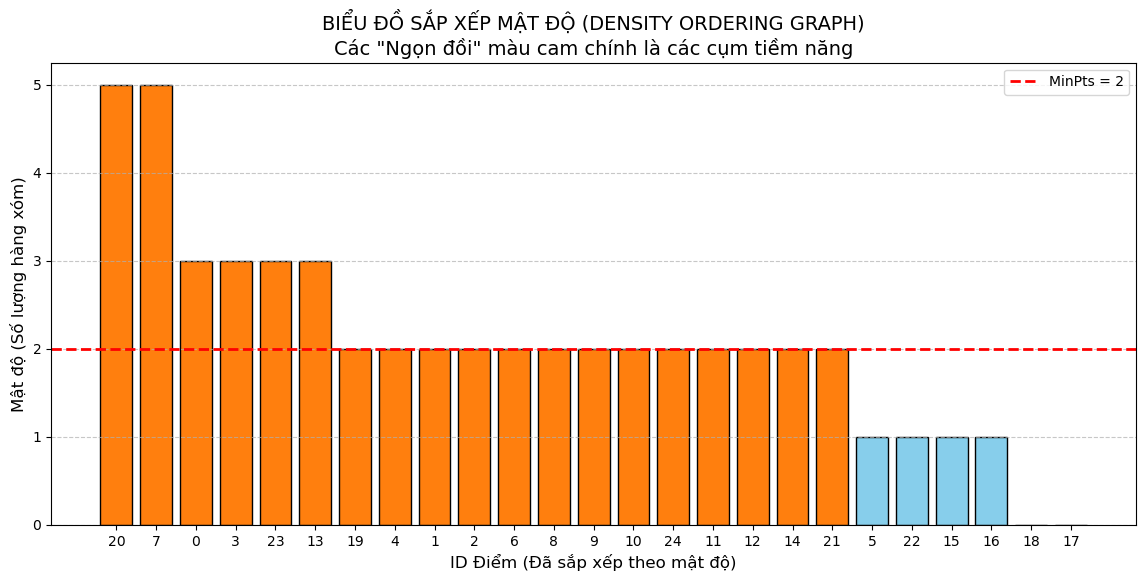

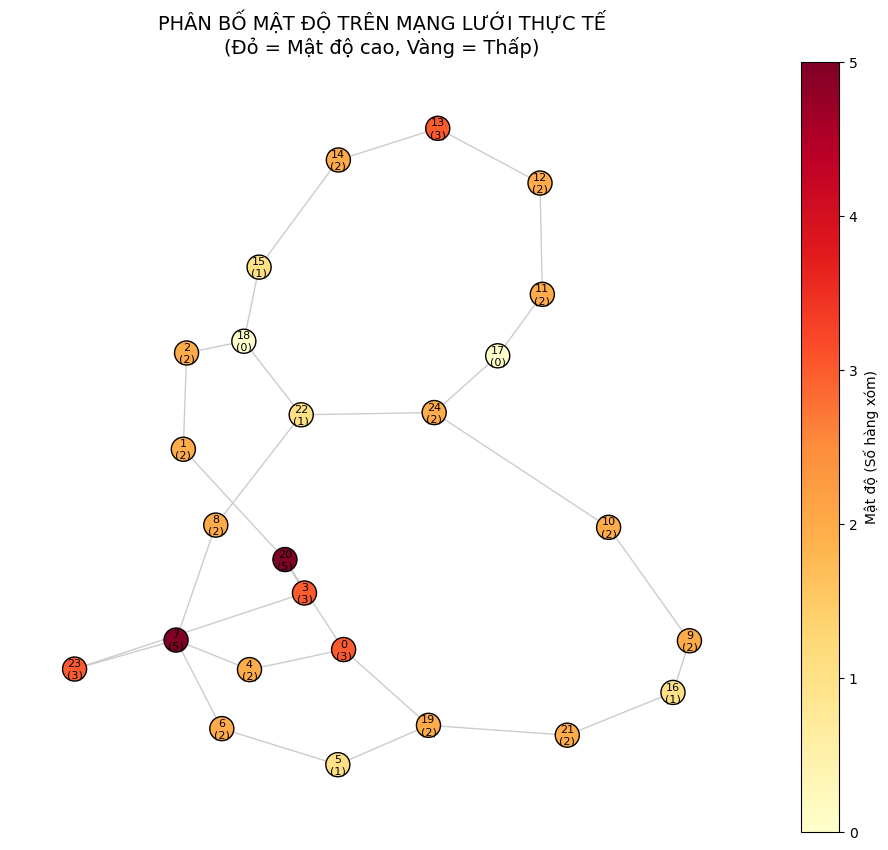

In [8]:
# ==========================================
# 4. CHẠY DEMO
# ==========================================
# Chọn Eps = 55.0 để quét
visualize_algo2_density(G, all_points, eps=55.0, pos=pos)